In [1]:
import torch
def normalized_linspace(length, dtype=None, device=None):
    """Generate a vector with values ranging from -1 to 1.
    Note that the values correspond to the "centre" of each cell, so
    -1 and 1 are always conceptually outside the bounds of the vector.
    For example, if length = 4, the following vector is generated:
    ```text
     [ -0.75, -0.25,  0.25,  0.75 ]
     ^              ^             ^
    -1              0             1
    ```
    Args:
        length: The length of the vector
    Returns:
        The generated vector
    """
    if isinstance(length, torch.Tensor):
        length = length.to(device, dtype)
    first = -(length - 1.0) / length
    return torch.arange(length, dtype=dtype, device=device) * (2.0 / length) + first

官方实现没有包含边界值，下面的实现包含了边界值，有没有包含边界值的区别是，结果中会不会出现边界
对于二维的情况：

In [2]:
#  B, C, Y, X = h.shape
#  x = torch.linspace(-1, 1, X)
#  y = torch.linspace(-1, 1, Y)

 对于三维的情况：

In [3]:
# B, C, Z, Y, X = h.shape
#  x = torch.linspace(-1, 1, X)
#  y = torch.linspace(-1, 1, Y)
#  z = torch.linspace(-1, 1, Z)

使用说明：[dsntnn/examples/basic_usage.md](https://github.com/anibali/dsntnn/blob/master/examples/basic_usage.md)

下面通过一个坐标点回归任务来学习dsnt的使用

下面首先创建一个简单的FCN模型，

In [5]:
import torch 
torch.manual_seed(12345)
from torch import nn
import dsntnn
class FCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
        )
    def forward(self, x):
        return self.layers(x)

DSNT层可以很方便的扩展到任何的FCN网络后面，来处理坐标点回归任务，下面就是一个例子

In [6]:
class CoordRegressionNetwork(nn.Module):
    def __init__(self, n_locations):
        super().__init__()
        self.fcn = FCN()
        self.hm_conv = nn.Conv2d(16, n_locations, kernel_size=1, bias=False)
 
    def forward(self, images):
        # 1. Run the images through our FCN
        fcn_out = self.fcn(images)
        # 2. Use a 1x1 conv to get one unnormalized heatmap per location
        unnormalized_heatmaps = self.hm_conv(fcn_out)
        # 3. Normalize the heatmaps
        heatmaps = dsntnn.flat_softmax(unnormalized_heatmaps)
        # 4. Calculate the coordinates
        coords = dsntnn.dsnt(heatmaps)
 
        return coords, heatmaps

训练模型

为了训练模型下面创建了一个小浣熊单只眼睛的图像

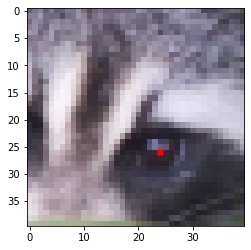

In [7]:
from torch import optim
import matplotlib.pyplot as plt
import scipy
import scipy.misc as sm
from skimage.transform import resize
 
image_size = [40, 40]
image = scipy.misc.face()[200:400, 600:800, :]
raccoon_face = resize(image, image_size)  # (40, 40, 3)
eye_x, eye_y = 24, 26
 
plt.imshow(raccoon_face)
plt.scatter([eye_x], [eye_y], color='red', marker='X')
plt.show()

由于DSNT输出的坐标范围是(-1, 1)，所以需要将target的坐标也归一化到这个范围

In [8]:
import torch
raccoon_face_tensor = torch.from_numpy(raccoon_face).permute(2, 0, 1).float()  # torch.Size([3, 40, 40])
input_tensor = raccoon_face_tensor.div(255).unsqueeze(0)  # torch.Size([1, 3, 40, 40])
input_var = input_tensor.cuda()
 
eye_coords_tensor = torch.Tensor([[[eye_x, eye_y]]])  # shape = [1, 1, 2],value=[[[24., 26.]]]
target_tensor = (eye_coords_tensor * 2 + 1) / torch.Tensor(image_size) - 1  # shape = [1, 1, 2],value=[[[0.2250, 0.3250]]]
target_var = target_tensor.cuda()
 
print('Target: {:0.4f}, {:0.4f}'.format(*list(target_tensor.squeeze())))


Target: 0.2250, 0.3250


现在我们训练模型，让模型在小浣熊的眼睛点出过拟合，全部的代码如下

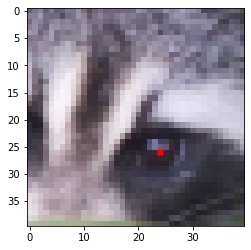

Target: 0.2250, 0.3250
Predicted coords: 0.2236, 0.3299


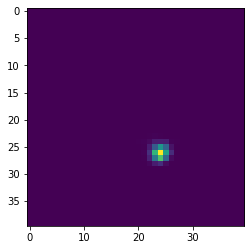

In [9]:
import scipy
import scipy.misc as sm
from skimage.transform import resize
import matplotlib.pyplot as plt
import torch
torch.manual_seed(12345)
from torch import nn
import dsntnn
import torch.optim as optim
class FCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
        )
    def forward(self, x):
        return self.layers(x)
class CoordRegressionNetwork(nn.Module):
    def __init__(self, n_locations):
        super().__init__()
        self.fcn = FCN()
        self.hm_conv = nn.Conv2d(16, n_locations, kernel_size=1, bias=False)
    def forward(self, images):
        # 1. Run the images through our FCN
        fcn_out = self.fcn(images)
        # 2. Use a 1x1 conv to get one unnormalized heatmap per location
        unnormalized_heatmaps = self.hm_conv(fcn_out)
        # 3. Normalize the heatmaps
        heatmaps = dsntnn.flat_softmax(unnormalized_heatmaps)
        # 4. Calculate the coordinates
        coords = dsntnn.dsnt(heatmaps)
        return coords, heatmaps
image_size = [40, 40]
# raccoon_face = sm.imresize(scipy.misc.face()[200:400, 600:800, :], image_size)      # (40, 40, 3)
image = scipy.misc.face()[200:400, 600:800, :]
raccoon_face = resize(image, image_size)
eye_x, eye_y = 24, 26
plt.imshow(raccoon_face)
plt.scatter([eye_x], [eye_y], color='red', marker='X')
plt.show()
raccoon_face_tensor = torch.from_numpy(raccoon_face).permute(2, 0, 1).float()   # torch.Size([3, 40, 40])
input_tensor = raccoon_face_tensor.div(255).unsqueeze(0)    # torch.Size([1, 3, 40, 40])
input_var = input_tensor.cuda()
eye_coords_tensor = torch.Tensor([[[eye_x, eye_y]]])    # # shape = [1, 1, 2],value=[[[24., 26.]]]
target_tensor = (eye_coords_tensor * 2 + 1) / torch.Tensor(image_size) - 1  # shape = [1, 1, 2],value=[[[0.2250, 0.3250]]]
target_var = target_tensor.cuda()
print('Target: {:0.4f}, {:0.4f}'.format(*list(target_tensor.squeeze())))
model = CoordRegressionNetwork(n_locations=1).cuda()    # n_locations=keypoint num=1
# coords, heatmaps = model(input_var)
# print('Initial prediction: {:0.4f}, {:0.4f}'.format(*list(coords[0, 0])))
# plt.imshow(heatmaps[0, 0].detach().cpu().numpy())
# plt.show()
optimizer = optim.RMSprop(model.parameters(), lr=2.5e-4)
for i in range(400):
    # Forward pass
    coords, heatmaps = model(input_var)
    # coords:shape=[1, 1, 2], value=[[[0.0323, 0.0566]]]; heatmaps:shape=[1, 1, 40, 40]
    # Per-location euclidean losses
    euc_losses = dsntnn.euclidean_losses(coords, target_var)
    # Per-location regularization losses
    reg_losses = dsntnn.js_reg_losses(heatmaps, target_var, sigma_t=1.0)
    # Combine losses into an overall loss
    loss = dsntnn.average_loss(euc_losses + reg_losses)
    # Calculate gradients
    optimizer.zero_grad()
    loss.backward()
    # Update model parameters with RMSprop
    optimizer.step()
# Predictions after training
print('Predicted coords: {:0.4f}, {:0.4f}'.format(*list(coords[0, 0])))
plt.imshow(heatmaps[0, 0].detach().cpu().numpy())
plt.show()



In [ ]:
import numpy as np
def DSNT_f(h, spacial=None):
    B, C, Z, Y, X = h.shape
    print("B, C, Z, Y, X", B, C, Z, Y, X)
    #heatmap = heatmap * 20
    #h = heatmap / torch.sum(heatmap, dim=(2, 3, 4), keepdim=True)
    x = torch.linspace(-1, 1, X)
    y = torch.linspace(-1, 1, Y)
    z = torch.linspace(-1, 1, Z)
    x_cord = x.view([B, 1, 1, 1, X])
    y_cord = y.view([B, 1, 1, Y, 1])
    z_cord = z.view([B, 1, Z, 1, 1])
    px = (h * x_cord).sum(dim=(2, 3)).sum(dim=-1)
    py = (h * y_cord).sum(dim=(2, 4)).sum(dim=-1)
    pz = (h * z_cord).sum(dim=(3, 4)).sum(dim=-1)

    #print(x_cord.shape, px.shape, px.view(B, C, 1, 1, 1).shape)
    var_x = (h * ((x_cord - px.view(B, C, 1, 1, 1)) ** 2)).sum(dim=(2, 3, 4))
    var_y = (h * (y_cord - py.view(B, C, 1, 1, 1)) ** 2).sum(dim=(2, 3, 4))
    var_z = (h * (z_cord - pz.view(B, C, 1, 1, 1)) ** 2).sum(dim=(2, 3, 4))
    return px, py, pz, var_x, var_y, var_z

x = np.random.rand(1, 1, 200, 128, 128)
h = torch.from_numpy(x)
print(h.shape())